In [1]:
import pandas as pd 
from pathlib import Path
import numpy as np
import json
import urllib
import PIL.Image as Image
import cv2
import torch
import torchvision
from IPython.display import display, Image
from sklearn.model_selection import train_test_split
import time
import datetime

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
!pip install ensemble-boxes
import os
import tarfile

In [2]:

url = "https://evp-ml-data.s3.us-east-2.amazonaws.com/ml-interview/openimages-personcar/trainval.tar.gz"
filename = os.path.join(os.getcwd(), "trainval.tar.gz")
keras.utils.get_file(filename, url)

tar = tarfile.open(filename)
tar.extractall()
tar.close()
base_folder =os.path.join(os.getcwd(), "trainval/")

'\nurl = "https://evp-ml-data.s3.us-east-2.amazonaws.com/ml-interview/openimages-personcar/trainval.tar.gz"\nfilename = os.path.join(os.getcwd(), "trainval.tar.gz")\nkeras.utils.get_file(filename, url)\nimport tarfile\ntar = tarfile.open(filename)\ntar.extractall()\ntar.close()\nbase_folder =os.path.join(os.getcwd(), "trainval/")\n'

In [2]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10

np.random.seed(42)

#base_folder =r'C:\Users\mbhattac\Downloads\temp\coco\\'


In [3]:
os.chdir(base_folder)

In [4]:
images = []
with open(base_folder +r'annotations\bbox-annotations.json') as f:
    config = json.load(f)
    
images=config['images']
annotations=config['annotations']
categories=config['categories']


filename = [ i['file_name'] for i in images]
ids = [ i['id'] for i in images]

images = {ids[i]: filename[i]  for i in range(len(filename))} 


annotations = pd.DataFrame.from_dict(annotations)

annotations['image_id'] = [images[_id] for _id in annotations.image_id]

annotations.drop(columns=['license','segmentation','id'],inplace=True)


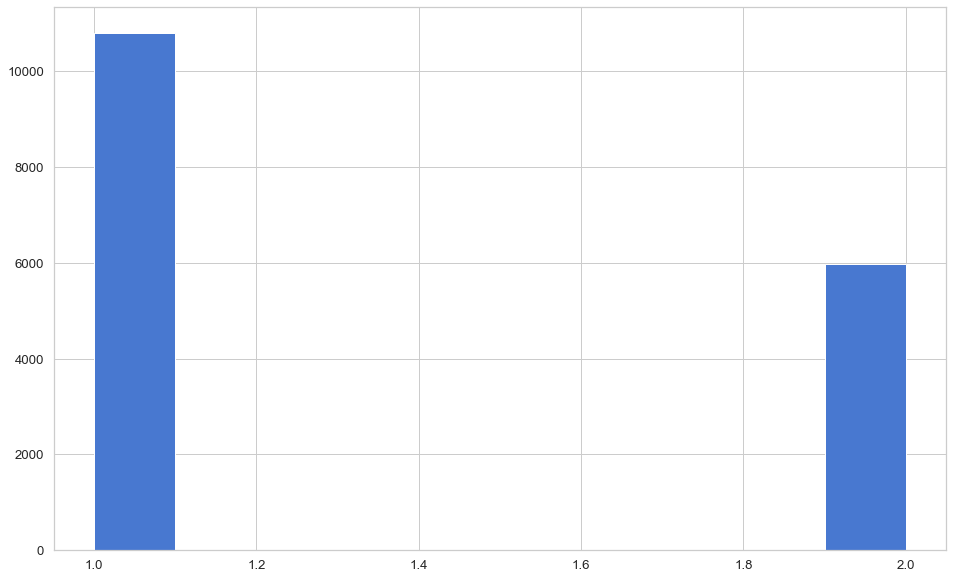

In [5]:
annotations.category_id.hist()

In [7]:
!pip install imbalanced-learn

In [6]:
from imblearn.under_sampling import RandomUnderSampler

In [7]:
undersample = RandomUnderSampler(sampling_strategy=1.0)

In [8]:
annotations.columns


Index(['category_id', 'image_id', 'iscrowd', 'bbox', 'area'], dtype='object')

In [9]:
annotations, _ = undersample.fit_resample(annotations, annotations.category_id)

In [10]:
annotations.columns

Index(['category_id', 'image_id', 'iscrowd', 'bbox', 'area'], dtype='object')

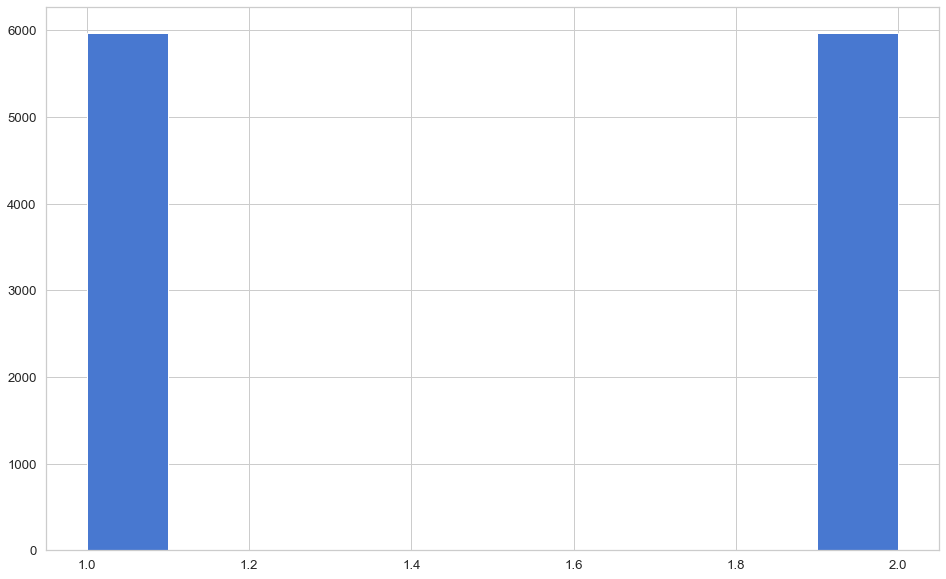

In [11]:
annotations.category_id.hist()

In [12]:
all_images = annotations.image_id.unique()

In [13]:
train_images, validation_images = train_test_split(all_images, test_size=0.3, shuffle=True)

In [14]:
train_images

array(['image_000000703.jpg', 'image_000001170.jpg',
       'image_000000616.jpg', ..., 'image_000000676.jpg',
       'image_000000831.jpg', 'image_000000809.jpg'], dtype=object)

In [15]:
train_a = annotations.loc[annotations.apply(lambda x: x.image_id in train_images,axis=1)]
val_a = annotations.loc[annotations.apply(lambda x: x.image_id in validation_images,axis=1)]


In [16]:
train_a.reset_index(inplace=True)
val_a.reset_index(inplace=True)

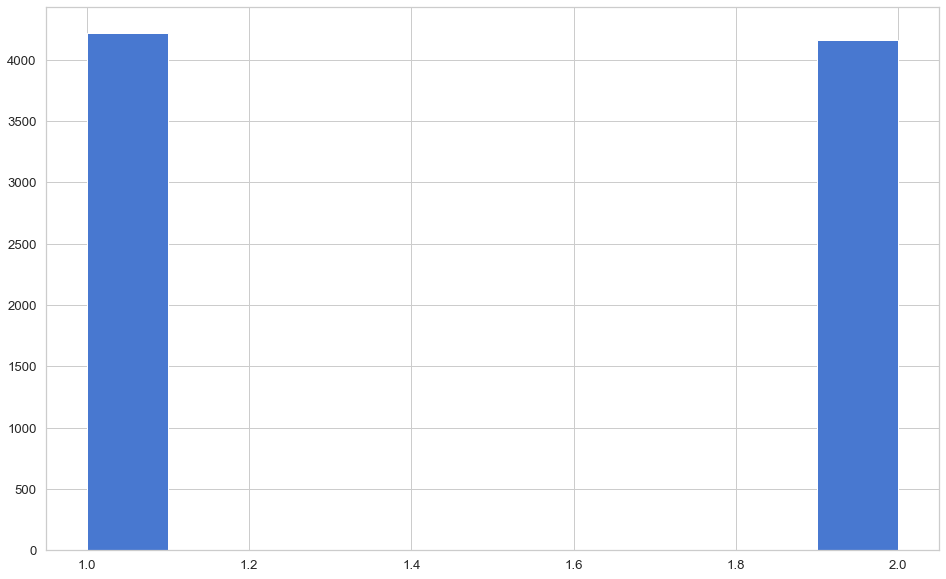

In [17]:
train_a.category_id.hist()

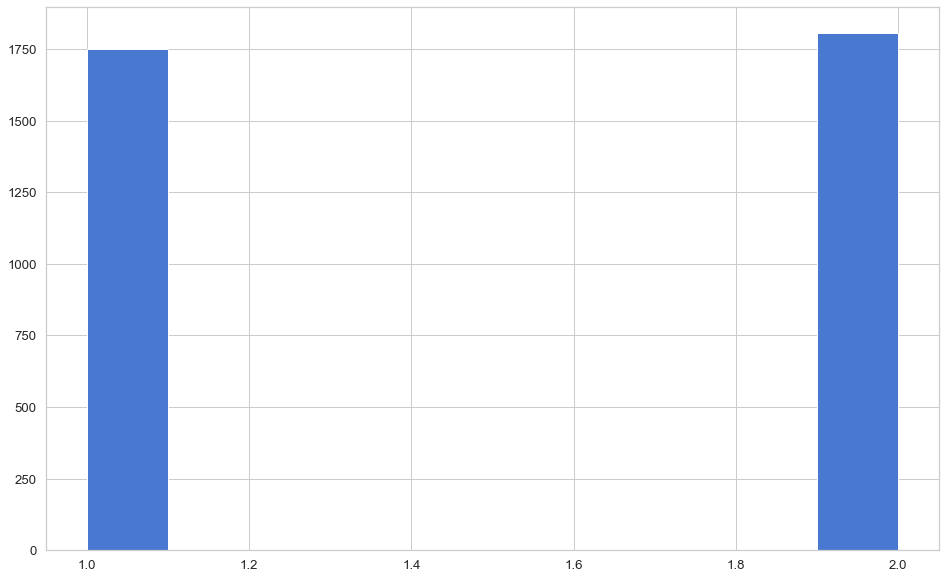

In [18]:
val_a.category_id.hist()

In [19]:
train_a.image_id.unique().shape

(1567,)

In [20]:
val_a.image_id.unique().shape

(672,)

In [21]:
train_a.loc[56]

index                           91
category_id                      1
image_id       image_000001491.jpg
iscrowd                          0
bbox           [794, 595, 99, 119]
area                     0.0160683
Name: 56, dtype: object

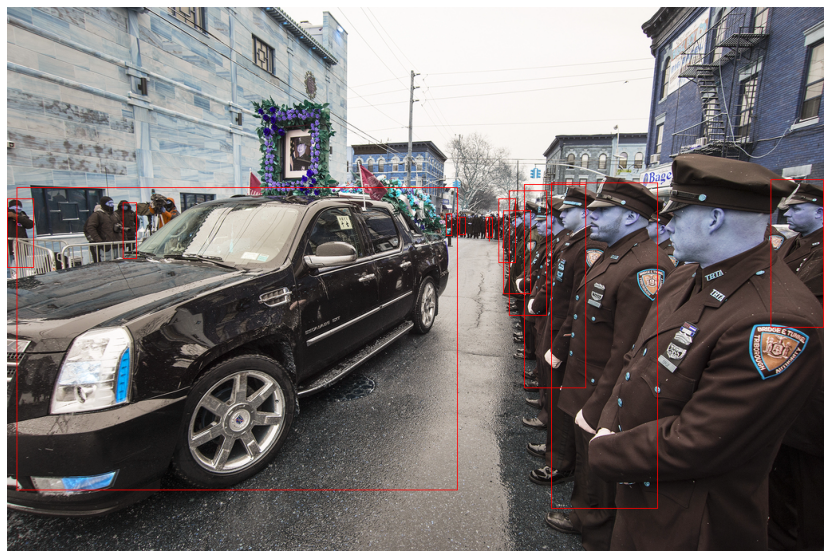

In [22]:
image_id='image_000001379.jpg'       
records = annotations[annotations['image_id'] == image_id]
image_dir = base_folder + '\images\\'
image = cv2.imread(f'{image_dir}/{image_id}', cv2.COLOR_BGR2RGB)
boxes = records.bbox.values
boxes =np.vstack(boxes)
for b in boxes:
    x,y,w,h=b
    image = cv2.rectangle(
          image,
          (int(x), int(y)),
          (int(x+w), int(y+h)),
          color=(255, 0, 0),
          thickness=1
        )
plt.axis('off')    
plt.imshow(image)

In [23]:
records.loc[records.area > 0.0].area


883     0.028116
1697    0.017484
1867    0.004064
2098    0.005063
2344    0.000221
3353    0.010499
3526    0.077701
3852    0.001704
4574    0.000286
5065    0.000271
5252    0.002406
9655    0.299567
Name: area, dtype: float64

In [24]:
class coco(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.df.loc[index].image_id 
        records = self.df[self.df['image_id'] == image_id]
        records= records.loc[records.area > 0.0] # some anotations have zero size, this can be increased to tune the efficiency of the detector, bigger the training instance better be the recognized feature

        image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        image = torch.as_tensor(image, dtype=torch.float32)        
        image= image.permute(2, 0, 1)
        boxes = records.bbox.values
        boxes =np.vstack(boxes).astype(int)
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        boxes = torch.as_tensor(boxes, dtype=torch.int64)
        #area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(records.area.values, dtype=torch.float32)
        labels = torch.as_tensor(records.category_id.values, dtype=torch.int64 )
        iscrowd = torch.as_tensor(records.iscrowd.values, dtype=torch.int64 )
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['area'] = area
        target['iscrowd'] = iscrowd

        return image, target,image_id
        

    def __len__(self) -> int:
        return self.df.shape[0]



In [25]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)


In [26]:
num_classes = 3  

In [27]:
in_features = model.roi_heads.box_predictor.cls_score.in_features

In [28]:
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [29]:
model.load_state_dict(torch.load(base_folder + r'coco_model.pth'))

<All keys matched successfully>

In [30]:
#Function to calculate loss for every epoch
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [31]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [32]:
train_dataset = coco(train_a,base_folder + '\images\\')
valid_dataset = coco(val_a,base_folder + '\images\\')

In [33]:
indices = torch.randperm(len(train_dataset)).tolist()

In [34]:
train_data_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

In [35]:
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area

In [36]:
def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1

    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx


def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0
    
    # for pred_idx, pred in enumerate(preds_sorted):
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1

        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)


def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    """Calculates image precision.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision


In [37]:
models = [model]

def make_ensemble_predictions(images):
    images = list(image.to(device) for image in images)    
    result = []
    for net in models:
        net.eval()
        outputs = net(images)
        result.append(outputs)
    return result

def run_wbf(predictions, image_index, image_size=1024, iou_thr=0.55, skip_box_thr=0.5, weights=None):
    boxes = [prediction[image_index]['boxes'].data.cpu().numpy()/(image_size-1) for prediction in predictions]
    scores = [prediction[image_index]['scores'].data.cpu().numpy() for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]) for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

In [38]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#device = torch.device('cpu')

In [39]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = None

num_epochs = 1

In [40]:
es_patience = 2
loss_hist = Averager()
best_val = None
patience = es_patience
for epoch in range(num_epochs):
    start_time = time.time()
    itr = 1
    loss_hist.reset()
    model.train()
    counter=3
    for images, targets, image_ids in train_data_loader:
        if counter == 0:
            continue
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if k =='labels' else v.float().to(device) for k, v in t.items()} for t in targets]#[{k: v.double().to(device) if k =='boxes' else v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 20 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
        #counter-=1
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    
    #At every epoch we will also calculate the validation IOU
    validation_image_precisions = []
    iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]
    model.eval()
    for images, targets,imageids in valid_data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if k =='labels' else v.float().to(device) for k, v in t.items()} for t in targets]
  
        
        predictions = make_ensemble_predictions(images)
   
        for i, image in enumerate(images):
            boxes, scores, labels = run_wbf(predictions, image_index=i)
            boxes = boxes.astype(np.int32).clip(min=0, max=1023)
            
            preds = boxes
            preds_sorted_idx = np.argsort(scores)[::-1]
            preds_sorted = preds[preds_sorted_idx]
            gt_boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
            image_precision = calculate_image_precision(preds_sorted,
                                                    gt_boxes,
                                                    thresholds=iou_thresholds,
                                                    form='coco')

            validation_image_precisions.append(image_precision)
    val_iou = np.mean(validation_image_precisions)
    print(f"Epoch #{epoch+1} loss: {loss_hist.value}","Validation IOU: {0:.4f}".format(val_iou),"Time taken :",str(datetime.timedelta(seconds=time.time() - start_time))[:7])
    if not best_val:
        best_val = val_iou  
        print("Saving model")
        torch.save(model.state_dict(), r'coco_model.pth') 
        #continue
    if val_iou >= best_val:
        print("Saving model as IOU is increased from",best_val,"to",val_iou)
        best_val = val_iou
        patience = es_patience  
        torch.save(model.state_dict(), r'coco_model.pth') 
    else:
        patience -= 1
        if patience == 0:
            print('Early stopping. Best Validation IOU: {:.3f}'.format(best_val))
            break

KeyboardInterrupt: 

In [41]:
model.eval()
torch.cuda.empty_cache()
cpu_device =  torch.device('cpu')
model=model.to(cpu_device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


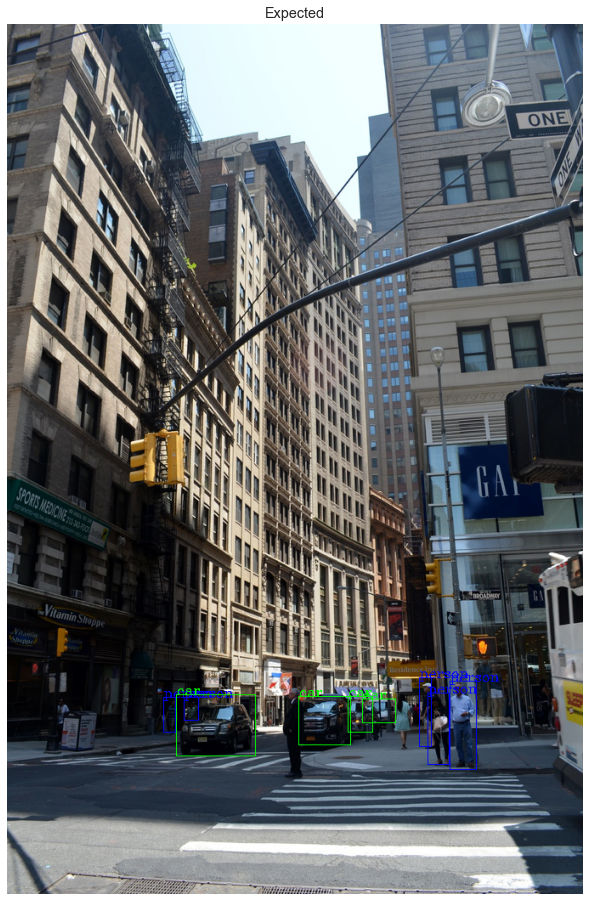

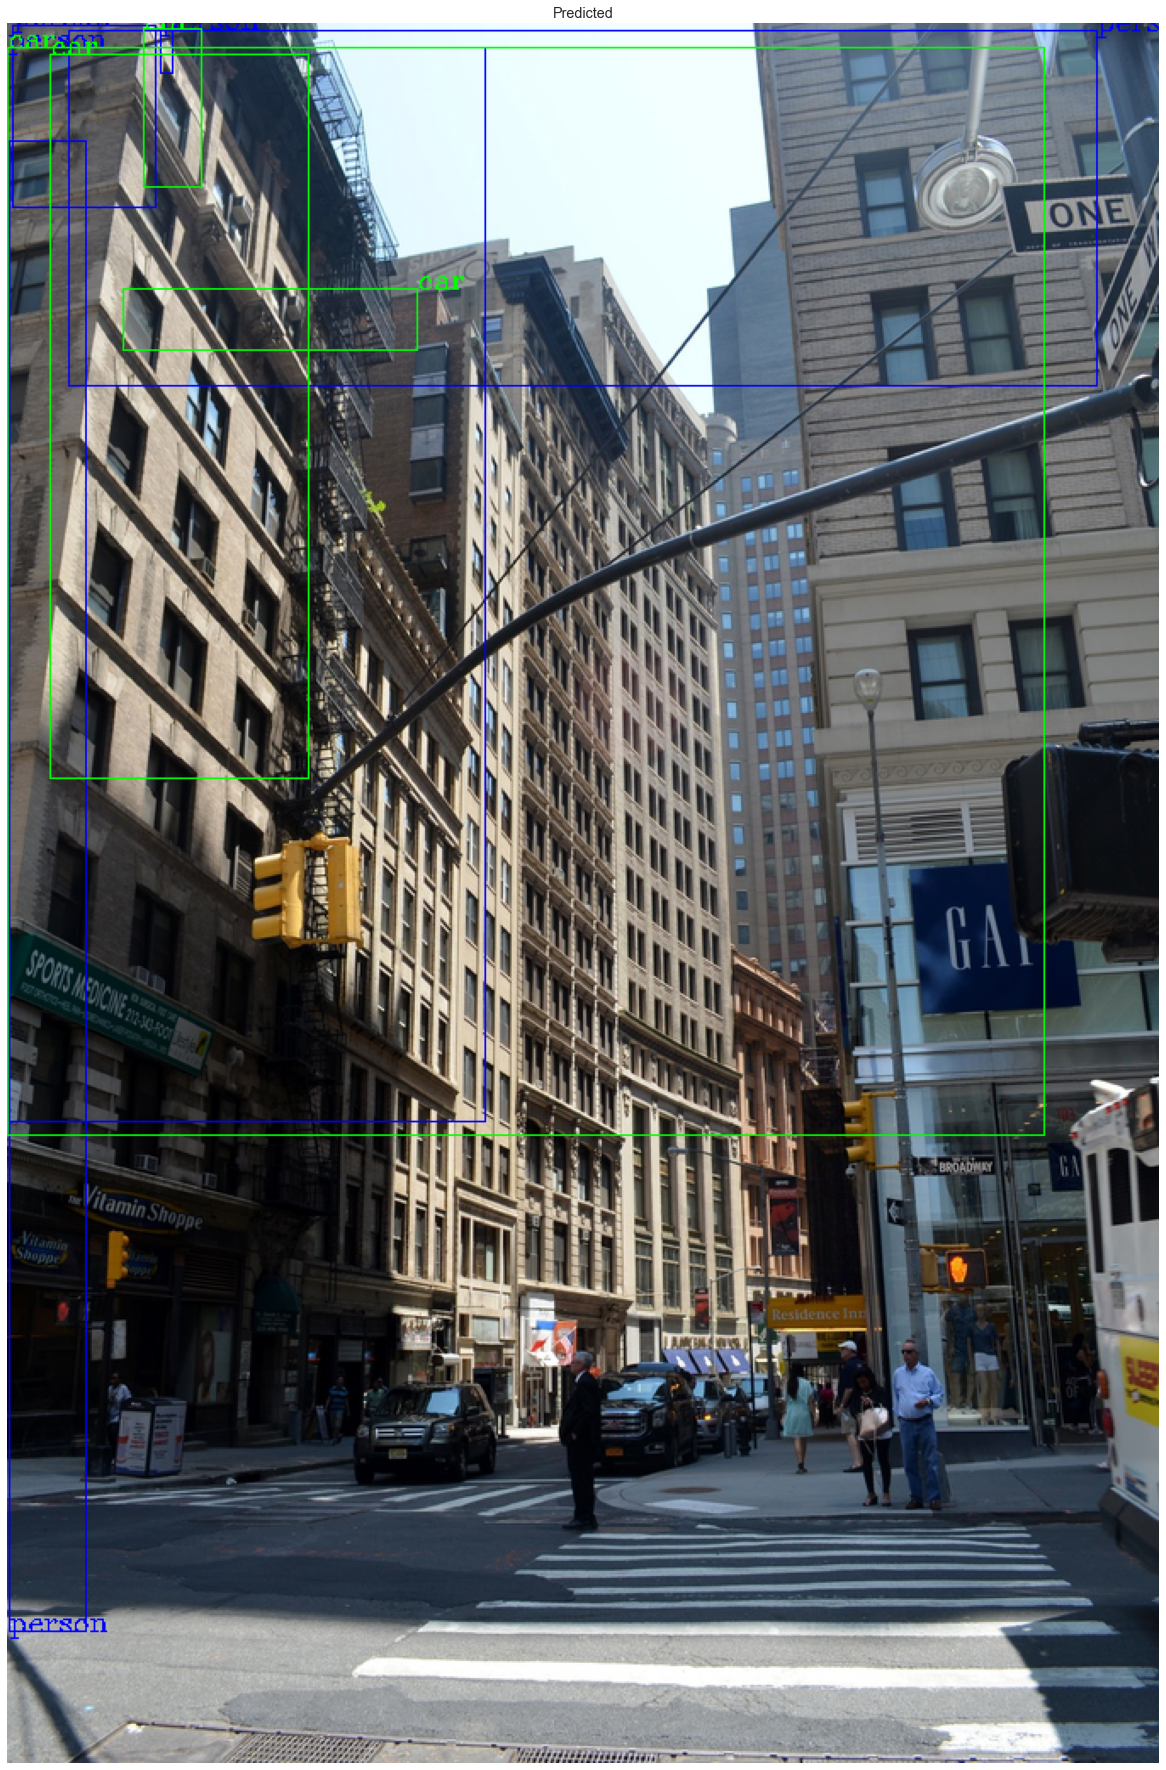

In [43]:
print_examples=1
for images, targets, image_ids  in valid_data_loader:
    if print_examples  >0:
        print_examples-=1
    else:
        break
            
    images = list(img.to(cpu_device) for img in images)
    targets = [{k: v.to(cpu_device) for k, v in t.items()} for t in targets]  
    boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[0].permute(1,2,0).cpu().numpy()
    labels  = targets[0]['labels'].cpu().numpy().astype(np.int32)    
    saved_sample = sample.copy()
    class_names = ['Error','person','car']
    fig, ax = plt.subplots(1, 1, figsize=(16, 16))
    for box,l in zip(boxes,labels):
        if l == 1:
            color = (0,0,255) 
        else:
            color = (0,255,0)

        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                          color=color,
                          thickness=1)
        cv2.putText(sample,class_names[l],(box[0], box[1]),cv2.FONT_HERSHEY_COMPLEX,0.5,color,1)
    ax.set_axis_off()
    ax.imshow(sample)
    ax.set_title('Expected')    
    # prediction
    outputs = model(images)    
    outputs=outputs[0]
    detection_threshold = 0.5

    boxes = outputs['boxes'].data.cpu().numpy()
    scores = outputs['scores'].data.cpu().numpy()

    #boxes = boxes[scores >= detection_threshold].astype(np.int32)
    #scores = scores[scores >= detection_threshold]

    boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
    boxes[:, 3] = boxes[:, 3] - boxes[:, 1]    
    sample = saved_sample.copy()
    fig, bx = plt.subplots(1, 1, figsize=(32, 32))
    for box,l in zip(boxes,labels):
        if l == 1:
            color = (0,0,255) 
        else:
            color = (0,255,0)

        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                          color=color,
                          thickness=1)
        cv2.putText(sample,class_names[l],(box[0], box[1]),cv2.FONT_HERSHEY_COMPLEX,0.5,color,1)
    bx.set_axis_off()
    bx.imshow(sample)
    bx.set_title('Predicted')    
    